In [1]:
import pyhf
import json
import copy
import jsonpatch
import numpy as np
import matplotlib.pyplot as plt


## Download the Model


In [2]:
! pyhf contrib download https://www.hepdata.net/record/resource/1408070?view=true sbottom-pallet

In [3]:
! cp sbottom-pallet/RegionA/BkgOnly.json lhood.json
! pyhf patchset extract sbottom-pallet/RegionA/patchset.json --name "sbottom_750_745_60" > patch.json

## Helper Functions


In [4]:
def make_model(channel_list):
    spec = json.load(open("lhood.json"))
    patch = json.load(open("patch.json"))
    spec = jsonpatch.apply_patch(spec, patch)
    spec["channels"] = [c for c in spec["channels"] if c["name"] in channel_list]

    ws = pyhf.Workspace(spec)
    model = ws.model(
        measurement_name="NormalMeasurement",
        modifier_settings={
            "normsys": {"interpcode": "code4"},
            "histosys": {"interpcode": "code4p"},
        },
    )
    data = ws.data(model)
    return ws, model, data

In [5]:
def fitresults(constraints=None):
    _, model, data = make_model(["CRtt_meff"])

    pyhf.set_backend("numpy", pyhf.optimize.minuit_optimizer(verbose=False))

    constraints = constraints or []
    init_pars = model.config.suggested_init()
    par_bounds = model.config.suggested_bounds()
    fixed_params = model.config.suggested_fixed()

    for idx, fixed_val in constraints:
        init_pars[idx] = min(0, fixed_val) # Require to be positive
        fixed_params[idx] = True
        par_bounds[idx] = (min(init_pars[idx], par_bounds[idx][0]),
                           max(init_pars[idx], par_bounds[idx][1]))

    result = pyhf.infer.mle.fit(
        data,
        model,
        init_pars=init_pars,
        par_bounds=par_bounds,
        fixed_params=fixed_params,
        return_uncertainties=True,
    )
    bestfit = result[:, 0]
    errors = result[:, 1]
    return model, data, bestfit, errors

## Calculate per-parameter Impact


In [6]:
def calc_impact(idx, b, e, i, width, poi_index):
    _, _, bb, ee = fitresults([(idx, b + e)])
    poi_up_post = bb[poi_index]

    _, _, bb, ee = fitresults([(idx, b - e)])
    poi_dn_post = bb[poi_index]

    _, _, bb, ee = fitresults([(idx, b + width)])
    poi_up_pre = bb[poi_index]

    _, _, bb, ee = fitresults([(idx, b - width)])
    poi_dn_pre = bb[poi_index]
    return np.asarray([poi_dn_post, poi_up_post, poi_dn_pre, poi_up_pre])

In [7]:
def get_impact_data():
    model, _, b, e = fitresults()
    widths = pyhf.tensorlib.concatenate(
        [
            model.config.param_set(k).width()
            for k, v in model.config.par_map.items()
            if model.config.param_set(k).constrained
        ]
    )
    initv = pyhf.tensorlib.concatenate(
        [
            model.config.param_set(k).suggested_init
            for k, v in model.config.par_map.items()
            if model.config.param_set(k).constrained
        ]
    )
    labels = np.asarray(
        [
            f"{k}[{i:02}]" if model.config.param_set(k).n_parameters > 1 else k
            for k in model.config.par_order
            if model.config.param_set(k).constrained
            for i in range(model.config.param_set(k).n_parameters)
        ]
    )
    poi_free = b[model.config.poi_index]
    impacts = []

    for i, width in enumerate(widths):
        if i == model.config.poi_index:
            continue
        if i % 5 == 0:
            print(i)
        impct = calc_impact(i, b[i], e[i], width, initv[i], model.config.poi_index)
        impacts.append(impct - poi_free)
    return np.asarray(impacts), labels

In [8]:
impacts, labels = get_impact_data()

0


/home/feickert/Code/GitHub/pyhf/src/pyhf/tensor/numpy_backend.py:332: RuntimeWarning: divide by zero encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/home/feickert/Code/GitHub/pyhf/src/pyhf/interpolators/code4.py:174: RuntimeWarning: invalid value encountered in greater_equal
  alphasets >= self.__alpha0, self.mask_on, self.mask_off
/home/feickert/Code/GitHub/pyhf/src/pyhf/interpolators/code4.py:185: RuntimeWarning: invalid value encountered in greater
  alphasets > -self.__alpha0, self.mask_on, self.mask_off
/home/feickert/Code/GitHub/pyhf/src/pyhf/interpolators/code4.py:204: RuntimeWarning: invalid value encountered in greater_equal
  exponents >= self.__alpha0, exponents, self.ones
/home/feickert/Code/GitHub/pyhf/src/pyhf/interpolators/code4p.py:60: RuntimeWarning: invalid value encountered in greater
  alphasets > 1, self.mask_on, self.mask_off
/home/feickert/Code/GitHub/pyhf/src/pyhf/interpolators/code4p.py:64: RuntimeWarning: invalid value encountered in less

10
15
20
25
30
35
40
45
50
55


## Make the plot!


In [9]:
impcord = np.argsort(np.max(np.abs(impacts[:, :2]), axis=1))
simpacts = impacts[impcord]
slabels = labels[impcord]

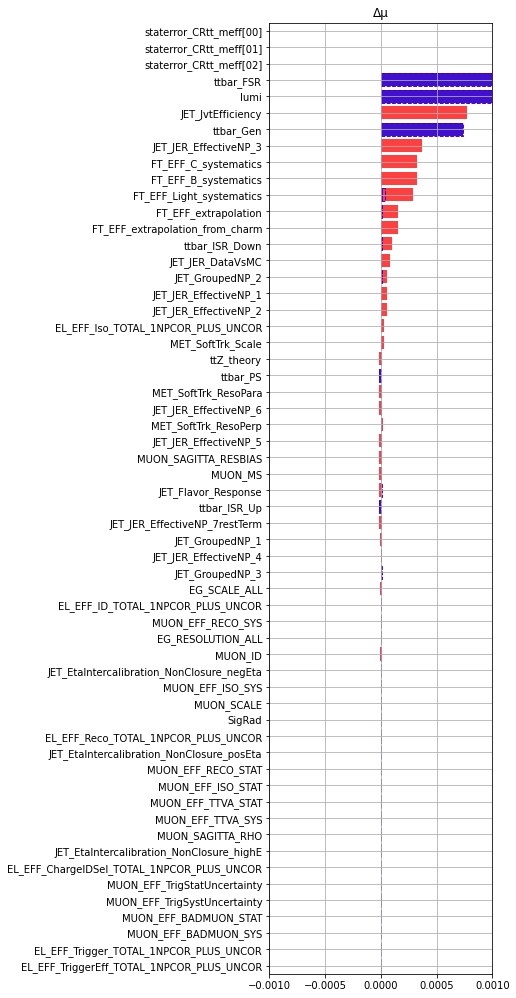

In [10]:
plt.barh(
    range(len(simpacts)),
    np.asarray(simpacts)[:, 0],
    alpha=0.75,
    linestyle="dashed",
    facecolor="r",
)
plt.barh(
    range(len(simpacts)),
    np.asarray(simpacts)[:, 1],
    alpha=0.75,
    linestyle="dashed",
    facecolor="b",
)
plt.barh(
    range(len(simpacts)),
    np.asarray(simpacts)[:, 2],
    alpha=0.75,
    linestyle="dashed",
    fill=None,
    edgecolor="r",
)
plt.barh(
    range(len(simpacts)),
    np.asarray(simpacts)[:, 3],
    alpha=0.75,
    linestyle="dashed",
    fill=None,
    edgecolor="b",
)
plt.xlim(-0.001, 0.001)
plt.ylim(-0.5, len(simpacts) - 0.5)
plt.gcf().set_size_inches(4, 17.5)
plt.title("Δµ")
plt.yticks(range(len(slabels)), slabels)
plt.grid();